#Import dataset from drive (Zip File)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/Frood_Drive/D_14.zip

Streaming output truncated to the last 5000 lines.
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.29.31 PM.png  
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.29.36 PM.png  
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.29.44 PM.png  
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.29.51 PM.png  
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.29.58 PM.png  
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.30.11 PM.png  
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.30.35 PM.png  
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.30.41 PM.png  
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.30.48 PM.png  
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.31.01 PM.png  
  inflating: D_14/Spoil Orange/translation_Screen Shot 2018-06-12 at 11.31.11 P

#Main process

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_14',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/D_14',
    color_mode='rgb',
    label_mode = 'categorical',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 25857 files belonging to 14 classes.
Using 20686 files for training.
Found 25857 files belonging to 14 classes.
Using 5171 files for validation.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [6]:
class_names = train_dataset.class_names

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset).numpy())
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset).numpy())
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset).numpy())

Number of training batches: 647
Number of validation batches: 81
Number of test batches: 81


In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

IMG_SHAPE = (224,224) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
base_model.trainable = False

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)

In [11]:
prediction_layer = tf.keras.layers.Dense(14, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)

In [12]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [13]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [14]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

81/81 [==============================] - 13s 71ms/step - loss: 3.2759 - accuracy: 0.0582
initial loss: 3.28
initial accuracy: 0.06


In [15]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
647/647 [==============================] - 58s 85ms/step - loss: 1.0879 - accuracy: 0.6957 - val_loss: 0.3633 - val_accuracy: 0.9368
Epoch 2/10
647/647 [==============================] - 50s 77ms/step - loss: 0.2858 - accuracy: 0.9371 - val_loss: 0.1906 - val_accuracy: 0.9608
Epoch 3/10
647/647 [==============================] - 50s 76ms/step - loss: 0.1739 - accuracy: 0.9613 - val_loss: 0.1331 - val_accuracy: 0.9705
Epoch 4/10
647/647 [==============================] - 51s 79ms/step - loss: 0.1267 - accuracy: 0.9708 - val_loss: 0.1058 - val_accuracy: 0.9756
Epoch 5/10
647/647 [==============================] - 50s 77ms/step - loss: 0.1019 - accuracy: 0.9759 - val_loss: 0.0850 - val_accuracy: 0.9806
Epoch 6/10
647/647 [==============================] - 50s 76ms/step - loss: 0.0839 - accuracy: 0.9796 - val_loss: 0.0742 - val_accuracy: 0.9841
Epoch 7/10
647/647 [==============================] - 50s 77ms/step - loss: 0.0697 - accuracy: 0.9844 - val_loss: 0.0638 - val_accuracy:

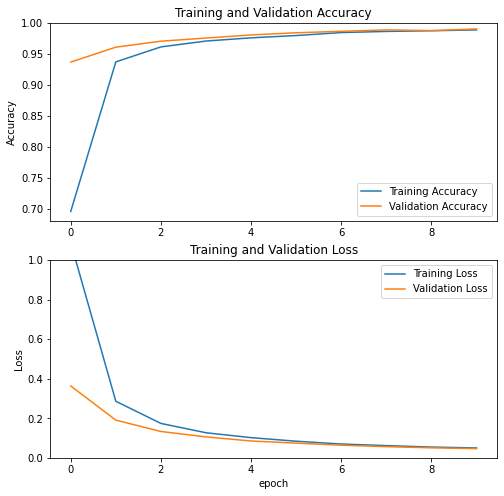

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning for better result

In [17]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [18]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                      

In [20]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/15
647/647 [==============================] - 61s 87ms/step - loss: 0.0333 - accuracy: 0.9895 - val_loss: 0.0285 - val_accuracy: 0.9876
Epoch 11/15
647/647 [==============================] - 56s 86ms/step - loss: 0.0130 - accuracy: 0.9968 - val_loss: 0.0104 - val_accuracy: 0.9957
Epoch 12/15
647/647 [==============================] - 55s 85ms/step - loss: 0.0082 - accuracy: 0.9971 - val_loss: 0.0075 - val_accuracy: 0.9977
Epoch 13/15
647/647 [==============================] - 55s 84ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.0081 - val_accuracy: 0.9973
Epoch 14/15
647/647 [==============================] - 55s 84ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0056 - val_accuracy: 0.9981
Epoch 15/15
647/647 [==============================] - 55s 85ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0020 - val_accuracy: 1.0000


In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

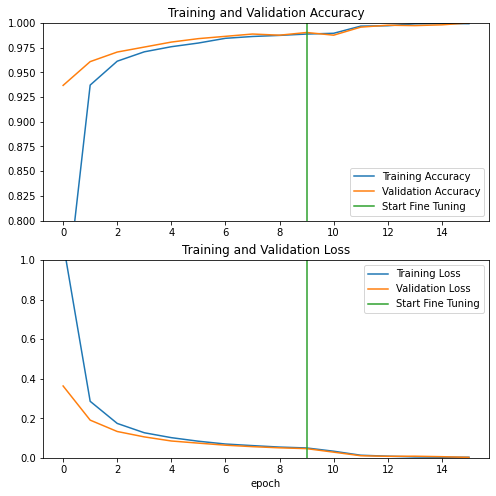

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Test Model Performance with test set

In [23]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

81/81 [==============================] - 6s 64ms/step - loss: 0.0072 - accuracy: 0.9996
Test accuracy : 0.9996141791343689


Predictions:
 [8, 1, 3, 7, 4, 1, 3, 4, 1, 3, 10, 11, 2, 10, 2, 0, 11, 3, 10, 0, 10, 13, 10, 3, 2, 13, 1, 10, 9, 0, 12, 1]
Labels:
 [8, 1, 3, 7, 4, 1, 3, 4, 1, 3, 10, 11, 2, 10, 2, 0, 11, 3, 10, 0, 10, 13, 10, 3, 2, 13, 1, 10, 9, 0, 12, 1]


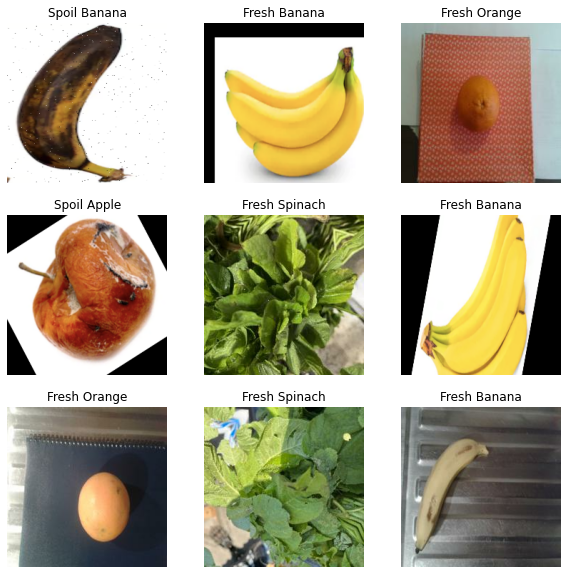

In [30]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

predictions = tf.nn.softmax(predictions)
predictions = list(np.argmax(x) for x in predictions.numpy())

print('Predictions:\n', predictions)
print('Labels:\n', list(np.argmax(x) for x in label_batch))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

#Confusion matrix

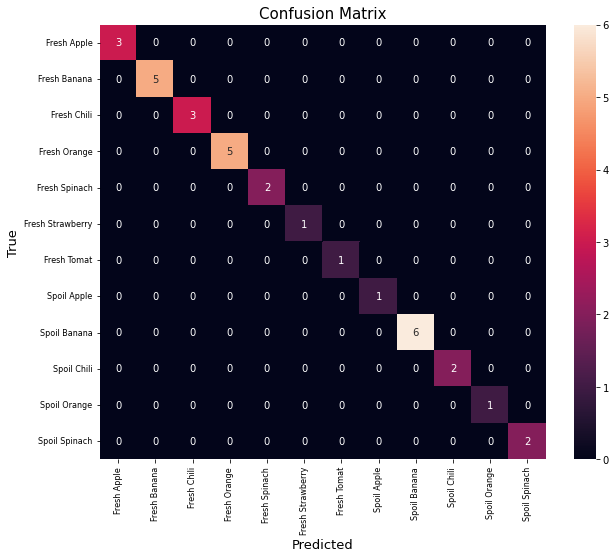

In [31]:
predictions = model.predict(image_batch, steps=len(image_batch), verbose=0)
y_pred = np.argmax(predictions, axis=-1)
y_true=np.argmax(label_batch, axis=-1)

cm = confusion_matrix(y_true, y_pred)

fig = plt.figure(figsize=(10, 8))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells

ax.set_xlabel('Predicted', fontsize=13)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 8)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=13)
ax.yaxis.set_ticklabels(class_names, fontsize = 8)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=15)

plt.savefig('ConMat24.png')
plt.show()

#Try Model With Custom Single Image

In [38]:
img = image.load_img(path='/content/chili3.jpg', target_size=(224,224))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
result = model.predict(img)
print(np.round_(result*100, decimals=2))

y_pred = np.argmax(result, axis=1)
print(y_pred)
if y_pred[0] == 0:
    print("Fresh Apple")
elif y_pred[0] == 1:
    print("Fresh Banana")
elif y_pred[0] == 2:
    print("Fresh Chilli")
elif y_pred[0] == 3:
    print("Fresh Orange")
elif y_pred[0] == 4:
    print("Fresh Spinach")
elif y_pred[0] == 5:
    print("Fresh Strawberry")
elif y_pred[0] == 6:
    print("Fresh Tomato")
elif y_pred[0] == 7:
    print("Spoil Apple")
elif y_pred[0] == 8:
    print("Spoil Banana")
elif y_pred[0] == 9:
    print("Spoil Chili")
elif y_pred[0] == 10:
    print("Spoil Orange")
elif y_pred[0] == 11:
    print("Spoil Spinach")
elif y_pred[0] == 12:
    print("Spoil Strawberry")
elif y_pred[0] == 13:
    print("Spoil Tomato")

[[1.000e-02 6.000e-02 9.992e+01 0.000e+00 0.000e+00 0.000e+00 0.000e+00
  0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.000e-02 0.000e+00 0.000e+00]]
[2]
Fresh Chilli


#Save Model

In [39]:
model.save('/content/Model_14_Class_Acc99.h5')